In [118]:
!pip install lightfm

In [119]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import the necessary libraries

In [120]:
import os
import random
import numpy as np
import pandas as pd
from scipy import sparse
import lightfm
from lightfm import LightFM, cross_validation
from lightfm.evaluation import precision_at_k, auc_score
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load the dataset

In [122]:
df_books = pd.read_csv('/content/drive/MyDrive/model-save/Books.csv', on_bad_lines='skip', encoding='latin-1')
df_users = pd.read_csv('/content/drive/MyDrive/model-save/Users.csv', on_bad_lines='skip', encoding='latin-1')
df_ratings = pd.read_csv('/content/drive/MyDrive/model-save/Ratings.csv', on_bad_lines='skip',
                          skiprows=lambda i: i>0 and random.random() > 0.50)

<ipython-input-122-066f13323942>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_books = pd.read_csv('/content/drive/MyDrive/model-save/Books.csv', on_bad_lines='skip', encoding='latin-1')


In [123]:
# what are the data types of all the columns that are present
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [124]:
df_books.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [125]:
# Lets remane some wierd columns name
df_books.rename(columns={"Book-Title":'title',
                      'Book-Author':'author',
                     "Year-Of-Publication":'year',
                     "Publisher":"publisher",
                     "Image-URL-L":"image_url"},inplace=True)

In [126]:
df_books.head()

,ISBN,title,author,year,publisher,Image-URL-S,Image-URL-M,image_url
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [127]:
df_books.iloc[237]['image_url']

'http://images.amazon.com/images/P/0671027387.01.LZZZZZZZ.jpg'

In [128]:
# what are the data types of all the columns that are present
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [129]:
# Lets remane some wierd columns name
df_users.rename(columns={"User-ID":'user_id',
                      'Location':'location',
                     "Age":'age'},inplace=True)

In [130]:
df_users.tail()

,user_id,location,age
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN
278857,278858,"dublin, n/a, ireland",NaN


In [131]:
# what are the data types of all the columns that are present
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575456 entries, 0 to 575455
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      575456 non-null  int64 
 1   ISBN         575456 non-null  object
 2   Book-Rating  575456 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 13.2+ MB


In [132]:
# Lets remane some wierd columns name
df_ratings.rename(columns={"User-ID":'user_id',
                      'Book-Rating':'rating'},inplace=True)

In [133]:
df_ratings.tail()

,user_id,ISBN,rating
575451,276704,0679752714,0
575452,276704,0743211383,7
575453,276704,1563526298,9
575454,276706,0679447156,0
575455,276721,0590442449,10


In [134]:
# Shape of the dataframe
print(df_books.shape, df_users.shape, df_ratings.shape, sep='\n')


(271360, 8)
(278858, 3)
(575456, 3)


In [135]:
df_ratings['user_id'].value_counts()

user_id
11676     6838
198711    3773
153662    3067
35859     2960
98391     2922
          ... 
115995       1
116000       1
116003       1
116004       1
276721       1
Name: count, Length: 71294, dtype: int64

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

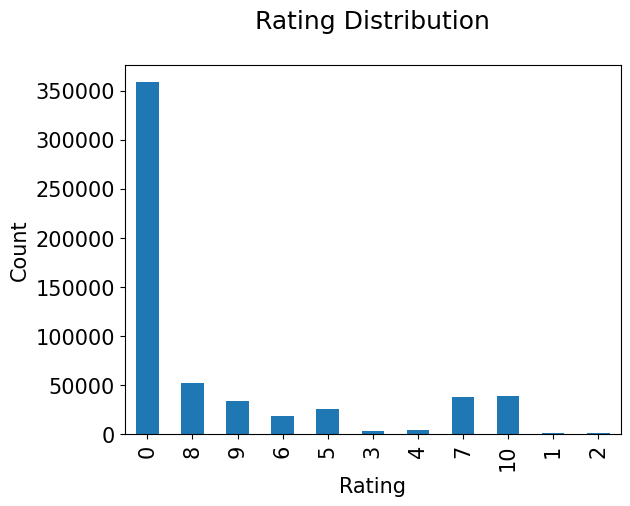

In [137]:
# Visualize the rating distributions
plt.rc("font", size=15)
df_ratings['rating'].value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('system1.png', bbox_inches='tight')
plt.show()

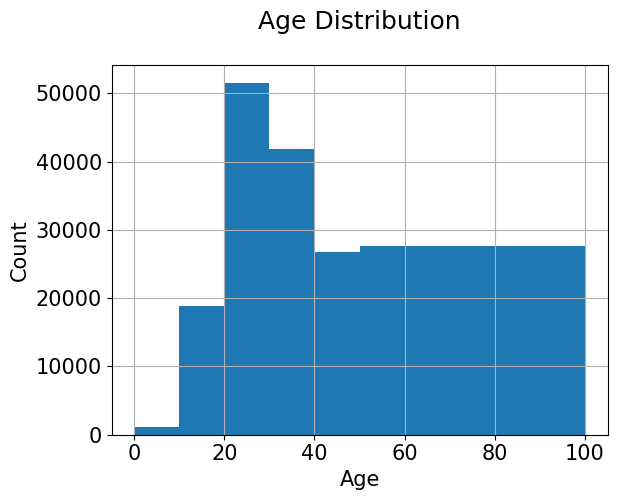

In [138]:
df_users['age'].hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('system2.png', bbox_inches='tight')
plt.show()

#### Check for missing values


In [139]:
df_books.isnull().sum()

ISBN           0
title          0
author         2
year           0
publisher      2
Image-URL-S    0
Image-URL-M    0
image_url      3
dtype: int64

In [140]:
df_users.isnull().sum()

user_id          0
location         0
age         110762
dtype: int64

In [141]:
df_ratings.isnull().sum()

user_id    0
ISBN       0
rating     0
dtype: int64

In [142]:
# Check the duplicates values
print(df_books.duplicated().sum())
print(df_users.duplicated().sum())
print(df_ratings.duplicated().sum())

0
0
0


In [143]:
# Handling missing values
# replacing the null valuess with null string
df_books['publisher'].fillna('', inplace=True)
df_books['author'].fillna('', inplace=True)
df_books['image_url'].fillna('', inplace=True)

# replacing the null valuess with median value of age
df_users['age'].fillna(df_users['age'].median(), inplace=True)

In [144]:
print(df_books.isnull().sum())
print('===========')
print(df_users.isnull().sum())
print('===========')
df_ratings.isnull().sum()

ISBN           0
title          0
author         0
year           0
publisher      0
Image-URL-S    0
Image-URL-M    0
image_url      0
dtype: int64
user_id     0
location    0
age         0
dtype: int64


user_id    0
ISBN       0
rating     0
dtype: int64

In [145]:
df_ratings = df_ratings.groupby('ISBN').filter(lambda x: len(x)>=100)
df_ratings

,user_id,ISBN,rating
85,276847,0446364193,0
219,276925,0385504209,8
232,276925,0971880107,0
310,276939,059035342X,0
326,276953,0446310786,10
...,...,...,...
575311,276680,0316666343,7
575327,276680,0385335482,0
575354,276680,0679781587,9
575388,276683,0345337662,0


In [146]:
df_ratings =df_ratings.groupby('ISBN').filter(lambda x: len(x)>=100)
df_ratings

,user_id,ISBN,rating
85,276847,0446364193,0
219,276925,0385504209,8
232,276925,0971880107,0
310,276939,059035342X,0
326,276953,0446310786,10
...,...,...,...
575311,276680,0316666343,7
575327,276680,0385335482,0
575354,276680,0679781587,9
575388,276683,0345337662,0


In [147]:
df_ratings = df_ratings[df_ratings.groupby('user_id').ISBN.transform('nunique')>=10]
df_ratings

,user_id,ISBN,rating
736,277427,014029628X,0
739,277427,0142001740,0
744,277427,0316096199,0
746,277427,0316284955,0
747,277427,0316776963,8
...,...,...,...
573973,275970,0440221471,0
573974,275970,0440222656,0
573975,275970,0440226430,0
574004,275970,0451524934,0


In [148]:
def create_interaction_matrix(df, user_col, item_col, rating_col, norm=False, threshold=None):
    interactions = df.groupby([user_col, item_col])[rating_col] \
        .sum().unstack().reset_index().fillna(0).set_index(user_col)
    if norm:
        interactions = interactions.applymap(lambda x: 1 if x > threshold else 0)
    return interactions

# Create the interaction matrix
interactions = create_interaction_matrix(df=df_ratings, user_col='user_id', item_col='ISBN', rating_col='rating', norm=False)
interactions.head()


ISBN,0060392452,0060502258,0060915544,0060928336,0060930535,0060934417,0060938455,0060959037,0060976845,0060977493,...,0804114986,080411868X,0805063897,0842329129,0971880107,1400034779,155874262X,1558743669,1559029838,1573229326
user_id,,,,,,,,,,,,,,,,,,,,,
243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0
254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
3363,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [149]:
def create_user_dict(interactions):
    user_id = list(interactions.index)
    user_dict = {}
    counter = 0
    for i in user_id:
        user_dict[i] = counter
        counter += 1
    return user_dict



# Create user dictionaries
user_dict = create_user_dict(interactions=interactions)
print(user_dict)




{243: 0, 254: 1, 882: 2, 2766: 3, 3363: 4, 4017: 5, 5903: 6, 6251: 7, 6543: 8, 6563: 9, 6575: 10, 7158: 11, 7346: 12, 7915: 13, 8253: 14, 8362: 15, 8681: 16, 9747: 17, 9856: 18, 10314: 19, 10447: 20, 11601: 21, 11676: 22, 12538: 23, 12824: 24, 13273: 25, 13552: 26, 14422: 27, 14521: 28, 15408: 29, 16634: 30, 16795: 31, 16916: 32, 17950: 33, 19664: 34, 20115: 35, 21014: 36, 21484: 37, 21659: 38, 22074: 39, 22625: 40, 23511: 41, 23768: 42, 24921: 43, 25131: 44, 26544: 45, 26593: 46, 27472: 47, 28177: 48, 28204: 49, 28523: 50, 28634: 51, 29259: 52, 30276: 53, 30487: 54, 30533: 55, 30711: 56, 30735: 57, 30972: 58, 31315: 59, 31556: 60, 32773: 61, 33974: 62, 35050: 63, 35857: 64, 35859: 65, 36003: 66, 36256: 67, 36606: 68, 36715: 69, 36836: 70, 37538: 71, 37712: 72, 37950: 73, 38023: 74, 39281: 75, 39616: 76, 39646: 77, 39773: 78, 40889: 79, 40943: 80, 41084: 81, 41841: 82, 42093: 83, 43246: 84, 43619: 85, 43687: 86, 43806: 87, 43842: 88, 44728: 89, 46398: 90, 47117: 91, 48046: 92, 48494: 9

In [151]:

# Convert interaction matrix to sparse matrix
x = sparse.csr_matrix(interactions.values)

# Split into train and test sets
train, test = lightfm.cross_validation.random_train_test_split(x, test_percentage=0.2, random_state=42)


In [152]:

def runMF(interactions, n_components=30, loss='warp', k=15, epoch=30, n_jobs=4):
    model = LightFM(no_components=n_components, loss=loss, k=k)
    model.fit(interactions, epochs=epoch, num_threads=n_jobs)
    return model

# Train the model
model = runMF(interactions=train, n_components=30, loss='warp', k=15, epoch=30, n_jobs=4)


In [153]:

# Evaluate the model
train_auc = auc_score(model, train, num_threads=4).mean()
print('Train AUC: %s' % train_auc)

test_auc = auc_score(model, test, train_interactions=train, num_threads=4).mean()
print('Test AUC: %s' % test_auc)

train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()

print('Train Precision: %.2f, Test Precision: %.2f' % (train_precision, test_precision))


Train AUC: 0.99934703
Test AUC: 0.54923797
Train Precision: 0.41, Test Precision: 0.02


In [154]:
def sample_recommendation_user(model, interactions, user_id, user_dict, item_dict, threshold=0, nrec_items=10, show=True):
    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x, np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))

    known_items = list(pd.Series(interactions.loc[user_id, :][interactions.loc[user_id, :] > threshold].index).sort_values(ascending=False))

    # Ensure the known_items and scores are in the item_dict
    known_items = [item for item in known_items if item in item_dict]
    scores = [item for item in scores if item in item_dict]

    return_score_list = scores[0:nrec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))

    if show:
        print("Known Ratings:")
        counter = 1
        for i in known_items:
            print(str(counter) + '- ' + i)
            counter += 1

        print("\nRecommended Items:")
        counter = 1
        for i in scores:
            print(str(counter) + '- ' + i)
            counter += 1
    return return_score_list

# Generate recommendations for specific users
user_id = 55492
rec_list = sample_recommendation_user(model=model, interactions=interactions, user_id=user_id, user_dict=user_dict, item_dict=item_dict, threshold=0, nrec_items=10, show=True)


Known Ratings:
1- Call of the Wild
2- Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
3- The Bridges of Madison County
4- Harry Potter and the Goblet of Fire (Book 4)
5- The Bad Beginning (A Series of Unfortunate Events, Book 1)
6- The Divine Secrets of the Ya-Ya Sisterhood: A Novel

Recommended Items:
1- Harry Potter and the Goblet of Fire (Book 4)
2- The Bad Beginning (A Series of Unfortunate Events, Book 1)
3- The Bridges of Madison County
4- The Divine Secrets of the Ya-Ya Sisterhood: A Novel
5- Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
6- Left Behind: A Novel of the Earth's Last Days (Left Behind No. 1)
7- Four To Score (A Stephanie Plum Novel)
8- Into the Wild
9- Fried Green Tomatoes at the Whistle Stop Cafe
10- All I Really Need to Know


In [155]:
user_id = 62891
rec_list = sample_recommendation_user(model=model, interactions=interactions, user_id=user_id, user_dict=user_dict, item_dict=item_dict, threshold=0, nrec_items=10, show=True)


Known Ratings:
1- The English Patient
2- The Bridges of Madison County
3- Red Dragon
4- Rising Sun
5- Congo
6- Jurassic Park
7- The Perfect Storm : A True Story of Men Against the Sea

Recommended Items:
1- Rising Sun
2- Congo
3- The Alienist
4- The English Patient
5- Jurassic Park
6- The Perfect Storm : A True Story of Men Against the Sea
7- Message in a Bottle
8- Sphere
9- Red Dragon
10- The Horse Whisperer
